# Spotify Models

<font color=red>Need bullshiting something for the start</font>

In this script, we include:

1. Baseline model: we adopt 'Jaccard similarity' to calculate similarity score of each pair of playlist in our dataset, and predict the tracks in similar playlists.

2. Advanced models
 - <font color=red>David's model 1
 - David's model 2
 - David's model n...</font>
 - artificial neural network: we use latent vector to create a collaborative filtering neural network and use the model to predict the "interaction" score for user(playlist) and item(track), we include the parameter selection process and the final model fitting

3. Combined model: combine baseline and advanced model together to generate the final recommendation list.

In [1]:
#import related packages
import json
import pandas as pd
import numpy as np
import scipy.sparse as sp
import keras
from keras import backend as K
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape, Flatten, add
from keras.optimizers import Adam
from keras.regularizers import l2
from time import time
import multiprocessing as mp
import sys
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from timeit import default_timer as timer

Using TensorFlow backend.


# Dataset Preparation

In [2]:
#count script running times
start = timer()

In [3]:
#function: combine separate dataset and get the 
#playlists(a dictionary with key of playlist id and value of a list of tracks)

#input: n is how many piece of data that will be generated(1 piece of data has 1,000 playlists)
#       m is the starting point(eg. the 1th piece of data)
#output: a dictionary containing users(playlists id) and track names

def load_dataset(n, m):
    c = m*1000
    playlists = {}
    for p in range(m, n+m):
        start = p*1000
        end = start+999
        with open('data/mpd.slice.{0}-{1}.json'.format(start, end)) as f:
            piece = json.load(f)
            play_list = [lst['tracks'] for lst in piece['playlists']]
            for ply in play_list:
                track_names = [track_name['track_name'] for track_name in ply]
                playlists[c] = track_names
                c += 1
    return playlists

In [4]:
#function: get the dataframe(index, user, track, interaction{1=interaction exists})
#input: a dictionary of playlist
#output: the cleaned dataframe

def get_data(playlists):
    users, items = [], []
    for user in playlists:
        for item in playlists[user]:
            users.append(user)
            items.append(item)
            
    data = pd.DataFrame(users, columns=['user'])
    data['track'] = items
    
    #encoding the track names into numbers
    data['track'] = data['track'].astype('category').cat.codes
    
    return data 

There will be two dataset to work on:
- the first is the full dataset including 10,000 playlists(the first 10 pieces of the whole dataset), it will be used for model training and tesing.
- the second dataset is the dataset used for model parameter optimization (cross validation to select best parameter)

The final dataset will be finally like:
![baseline model](image/data_example.jpg)

where "user" is defined as each individual playlist. The "track" is randomly selected tracks in the full dataset, noted that each track is encoded into numbers. The "y" is the interaction of the user and item(playlist). If the track exists in the playlist, the "y" (interaction) will be 1, otherwise it will be 0.

In [5]:
#Define the size of data
n_playlist = 10
m_playlist = 0
n_adjust = 1
m_adjust = 10

In [6]:
#Get the two dataset
data_full = get_data(load_dataset(n_playlist, m_playlist))
data_adjust = get_data(load_dataset(n_adjust, m_adjust))
data_adjust.user = data_adjust.user-m_adjust*1000

# Baseline Model

**Model Description**

The baseline model is based on comparing each pair of “tracks” and hence computing the “similarity score” by using the 'Jaccard similarity' similarity measurement:
![jaccard similarity](image/jaccard_similarity.jpg)

The dataset we use in baseline model is the full dataset(10,000) playlist.

The baseline model assumes that one user owns at least one playlist, and it computes the similarity score
of this user playlist with each of the playlists in the dataset. The recommendation tracks will be generated from
the playlist that has the highest similarity with the user playlist.

In this model, we only include a sample dataset of 10,000 playlists from the whole dataset (1 million
playlists). We split the sample dataset into a Playlist Bank and a Training set. The Playlist Bank contains
90% of the data (9,000) playlists and the Training Set contains 10% of the data(1,000) playlists. For each playlist in the Training Set, we hide one track to be the track that we try to predict, and we set the rest as our predictors. For each training list, if the hidden track exist in our prediction track list, we will define the error rate of this training list to 0, otherwise, to 1. And we average the total error of 500 playlists to be our total error rate.

For the final recommendation tracks, we will first get the not-overlap tracks in top 5 similary playlists, and randomly select 100 as our recommendation.

**Model design**

![baseline model](image/baseline_model.jpg)

In [7]:
#split the data into playlist bank (90%) and training set (10%)
playlist_bank = {}
for user in range(n_playlist*900):
    playlist_bank[user] = list(data_full[data_full['user']==user]['track'])

playlist_data = {}
for user in range(n_playlist*900, n_playlist*1000):
    playlist_data[user] = list(data_full[data_full['user']==user]['track'])

In [8]:
#check out the length of playlist bank and the training set
print(len(playlist_bank))
print(len(playlist_data))

9000
1000


In [9]:
#define the similarity function
#input: two list with items
#output: the similairty score of two lists
def cal_similarity(list_one, list_two):
    no_overlap = list(Counter(list_one)-Counter(list_two))
    similarity = ((len(list_one)-len(no_overlap))*2)/(len(list_one)+len(list_two))
    return similarity

In [10]:
# Create the function to hide the first track in each playlist
#input: the dictionary of playlists
#output: a list of the hidden track and a dictionary of users and the unhidden tracks
def hide_track(playlists):
    track_hide = []
    track_train = {}
    for key in playlists:
        track_hide.append(playlists[key][0])
        track_train[key] = playlists[key][1:]
    return track_hide, track_train

In [11]:
# Create the function of getting the recommendation list
#input: the playlists that is to be predicted
#       the playlist bank
#       the number of similar playlist that need to be generated
#output: the list of recommendation tracks

def get_recommendation_list(track_train, playlist_bank, no_similar_playlist):
    recommendation_track = []
    time_train = 0
    for ut in track_train:
        sim_score = np.zeros(len(playlist_bank))
        time_bank = 0
        for ub in playlist_bank:
            sim_score[time_bank] = cal_similarity(track_train[ut], playlist_bank[ub])
            time_bank += 1
        similarity_df = pd.DataFrame(sim_score, index=range(len(sim_score)))
        similarity_df = similarity_df.sort_values(by=0, ascending=False)
        index = list(similarity_df.index[[x for x in range(no_similar_playlist)]])
        sample_names = []
        for i in index:
            sample_names.append(playlist_bank[i])
        recommendation_track.append([track for playlist in sample_names for track in playlist])
        time_train += 1
    return recommendation_track    

In [12]:
#Get the list of hidden track and the dictionary of training tracks
track_hide, track_train_base = hide_track(playlist_data)

In [13]:
#Get the top 5 similar playlists as our base of recommendation list
#Randomly select 100 of them as our final recommendation
recommendation_list = get_recommendation_list(track_train_base, playlist_bank, 5)
no_recommendation = 100

In [14]:
#Calculate the score of the prediction
scores = np.zeros(len(track_train_base))
for n in range(len(track_hide)):
    not_overlap = list(Counter(recommendation_list[n])-Counter(track_train_base[n+900*m_adjust]))
    np.random.shuffle(not_overlap)
    recommendation = np.array(not_overlap)[:no_recommendation]
    if track_hide[n] in recommendation:
        scores[n] = 1
score = np.mean(scores)    

In [40]:
print('The score is {0}'.format(score))

The score is 0.171


We can see that the score is very low of this baseline model because it has several limiations:

1. Bias in calculating similarity score: although the process of finding the hidden track is supervised, the process of calculating similarity score is actually unsupervised since we don’t have an exact benchmark for “similarity of two playlists”. Therefore, the similarity score we calculated may be hesitated.

2. Even though we find the top 5 similar playlists, we applied no but the random selection techque in choosing the 100 tracks as our recommendation. Other critera will be explored in advanced models.

3. Too much related to the sample size: the sample is small, and it only contains 1% of the original dataset. The bigger the Playlist Bank, the higher the probability we find a “twin” of our training list.

4. Predictor selection: the only predictor we use to compute the similarity is “track_name” in the playlist. However, there are more predictors in the dataset that seem to be useful, such as “album_name”, “artist_name”, “popular_artist”, “popular_album”, “playlist_name”, and so on. They will be exlored in the advanced modeling.

5. Computation cost: the computation cost need to be reduced.

7. Cold-start problem: since the model assumes that there is already an existing playlist for one user, it does not take the “cold-start” problem into account. This issue should be discussed in the advanced model.

# Improved Models

<font color=red>Say something for starting...</font>

<font color=red>Input Davids models</font>

## Artificial Neural Network


Our artificial neural network is based on the research of the paper: **Neural Collaborative Filtering** https://arxiv.org/pdf/1708.05031.pdf. In this paper, the matrix factorization and lantent vector technique is applied to deal with the input of data and these two techniques will be used in the artificial neural network we created.

**Model Description**

We will do a little manipulation in our data to put it into a matrix: matrix shown below.
Each row of the matrix represent the user(playlist) and each column of matrix represent the item(tracks). The value of the matrix is the "interaction". We mark "1" as the interaction of user and item exist and 0 otherwise. As illustrated before, the "interaction" means that the user have the item in his/her pocket.
![Compare](image/compare.jpg)

Matrix Factorization (MF) associates each user and item with a real-valued vector of latent features. It is shown below. The latent features are presented in the right handside of the above figures as compared with the matrix. As the research of **Neural Collaborative Filtering** indicated, there are some differences between "Jaccard similarity" and the "matrix factorization": in matrix, the u4 is most similar to u1, followed by u3 and u2 while in MF, the P4 is similar to P1, followed by P2 and P3 which indicated the "ranking lost" of MF. This could be one of the source of the model limitations.
![MF](image/mf.jpg)

**Model Design**

Our neural network aimed to estimate the function to predict the y_hat(ui). The input layer includes two dataset: the "user" and "track". The second layer is the embedding layer with user latent vector and track latent vector. And we added other layers in neural network to tune our predictions. The output layer is the predicted "interaction" ('y' in dataset). The prediction score is a probability ranged from 0 to 1. The probability indicated the likelyhood of the iteraction between the playlist and track. The higher the probability, the more likely that the user will like the track.
![Neural Network Model](image/neural_network_model.jpg)

**Adjusting Model Parameter**

There are several parameters here that we need to adjust while we could not show the process of all of it for this scope of project. Hence, we apply most of the parameters tested in previous paper and show just three of them in this project: latent_dims, learning rate, epochs.

The dataset we use adjust the parameters is the data_adjust, which take the 10th piece of the original data(1000 playlists). We seperate the data into training and testing(validation) set for the ratio of 0.8 to 0.2. After adjuting the parameter, we build our final model for the optimal parameters and fit the full dataset(10,000 playlist) like we did in previous model.

**About Prediction**

The prediction of this model will not be a recommendation list but the likelihood of if the user will posisbly interact with each specific track.

In [19]:
#create the matrix for (user, track)
#input: a dataframe of (user, track, interaction)
#output: the designed matrix
def get_matrix(data, no_interaction):
    num_user = len(data['user'].unique())
    num_track = len(data['track'].unique())
    data_matrix = sp.dok_matrix((num_user, num_track), dtype=np.float32)
    for u, t in zip(data['user'], data['track']):
        data_matrix[u, t] = 1.0
    return num_user, num_track, data_matrix

**As we know, the unique tracks in all the 10,000 playlists will be huge. Hence, if we use all the tracks that exist and donnot exist in each individual user, the portion of "not existing" tracks will be much bigger than that of "existing tracks". Therefore, if we do so, our prediction will always prediction the track to "not exist" in the playlist and we will get a high score of 0.99999999. It doesn't make sense though.**

**So the following functions is to randomly get our training data to make it include 0.5-0.5 true and false response portion in both our training and test set so that our decision boundry will be 0.5 as default in neural network.**

In [20]:
#get the random features
#input: the data matrix
#output: the desighed user, track input and response variable
def get_features(data_matrix):
    num_user, num_track = data_matrix.shape
    user_data, track_data, y_data = [],[],[]
    
    for (u, i) in data_matrix.keys():
        user_data.append(u)
        track_data.append(i)
        y_data.append(1)
        
        for t in range(no_interaction):
            j = np.random.randint(num_track)
            while (u,j) in data_matrix:
                j = np.random.randint(num_user)
            user_data.append(u)
            track_data.append(j)
            y_data.append(0)
                
    return user_data, track_data, y_data

In [21]:
#build the model
def build_model(num_user, num_track, latent_dim):
    user_train = Input(shape=(1,), dtype='int32', name = 'user_train')
    track_train = Input(shape=(1,), dtype='int32', name = 'track_train')

    MF_Embedding_user = Embedding(input_dim = num_user, output_dim = latent_dim, embeddings_initializer='uniform', embeddings_regularizer = l2([0,0][0]), input_length=1)
    MF_Embedding_track = Embedding(input_dim = num_track, output_dim = latent_dim, embeddings_initializer='uniform', embeddings_regularizer = l2([0,0][0]), input_length=1)   
    
    user_latent = Flatten()(MF_Embedding_user(user_train))
    track_latent = Flatten()(MF_Embedding_track(track_train))

    predictor = add([user_latent, track_latent])
    prediction = Dense(1, activation="sigmoid", name="prediction", kernel_initializer="lecun_uniform")(predictor)
    NNmodel = Model(inputs=[user_train, track_train], outputs=prediction)
    return NNmodel

**Parameter Selection**

In [22]:
#define the function to make plot for selection parameters
def make_plot(x, y_train, y_test, name):
    fig, ax = plt.subplots(1,1, figsize=(8, 5))
    ax.plot(x, y_train, label='train')
    ax.plot(x, y_test, label='test')
    ax.set_xlabel(name)
    ax.set_ylabel('scores')
    ax.set_title('{} Selection'.format(name))
    ax.legend()
    return

In [23]:
#get matrix
no_interaction = 1
num_user, num_track, matrix = get_matrix(data_adjust, no_interaction)
user, track, y = get_features(matrix)
data_nn = pd.DataFrame(user, columns=['user'])
data_nn['track'] = track
data_nn['y'] = y

#get train and test data
data_copy = data_nn.copy()
data_test = pd.DataFrame(columns=['user', 'track', 'y'])
for n in range(n_adjust*900, n_adjust*1000):
    data_hide = data_copy[data_copy.user == n].iloc[0:2]
    data_test = data_test.append(data_hide)
    
data_train = data_copy.drop(data_test.index)

user_train = data_train.user
track_train = data_train.track
y_train = data_train.y

user_test = data_test.user
track_test = data_test.track
y_test = data_test.y

In [24]:
#define parameter range
latent_dims = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 100]
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
epochss = [3, 20]

**1. Latent Dimension Selection**

In [25]:
learning_rate = learning_rates[1]
epochs = epochss[0]
latent_dim_list, train_score_list, test_score_list = [], [], []
for latent_dim in latent_dims:
    NNmodel = build_model(num_user, num_track, latent_dim)
    NNmodel.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    NNmodel.fit([np.array(user_train), np.array(track_train)], np.array(y_train), epochs=epochs, batch_size=200, validation_split = .2)
    NN_train_score = NNmodel.evaluate([np.array(user_train), np.array(track_train)], np.array(y_train))[1]
    NN_test_score = NNmodel.evaluate([np.array(user_test), np.array(track_test)], np.array(y_test))[1]
    latent_dim_list.append(latent_dim)
    train_score_list.append(NN_train_score)
    test_score_list.append(NN_test_score)

Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 2s 22us/step - loss: 0.6928 - acc: 0.5133 - val_loss: 0.6918 - val_acc: 0.5376
Epoch 2/3
104548/104548 [==============================] - 2s 21us/step - loss: 0.6885 - acc: 0.5846 - val_loss: 0.6888 - val_acc: 0.5619
Epoch 3/3
200/200 [==============================] - 0s 74us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 3s 26us/step - loss: 0.6922 - acc: 0.5174 - val_loss: 0.6905 - val_acc: 0.5374
Epoch 2/3
104548/104548 [==============================] - 3s 25us/step - loss: 0.6824 - acc: 0.6081 - val_loss: 0.6847 - val_acc: 0.5613
Epoch 3/3
200/200 [==============================] - 0s 53us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 3s 27us/step - loss: 0.6922 - acc: 0.5173 - val_loss: 0.6902 - val_acc: 0.5419
Epoch 2/3
104548/104548 [

104548/104548 [==============================] - 19s 178us/step - loss: 0.6868 - acc: 0.5383 - val_loss: 0.6740 - val_acc: 0.5755
Epoch 2/3
104548/104548 [==============================] - 18s 170us/step - loss: 0.6214 - acc: 0.6744 - val_loss: 0.6872 - val_acc: 0.5800
Epoch 3/3
200/200 [==============================] - 0s 70us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 21s 197us/step - loss: 0.6864 - acc: 0.5379 - val_loss: 0.6733 - val_acc: 0.5725
Epoch 2/3
104548/104548 [==============================] - 20s 190us/step - loss: 0.6191 - acc: 0.6729 - val_loss: 0.6904 - val_acc: 0.5792
Epoch 3/3
200/200 [==============================] - 0s 60us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 25s 242us/step - loss: 0.6857 - acc: 0.5380 - val_loss: 0.6714 - val_acc: 0.5789
Epoch 2/3
104548/104548 [==============================] - 25s 237us/step - 

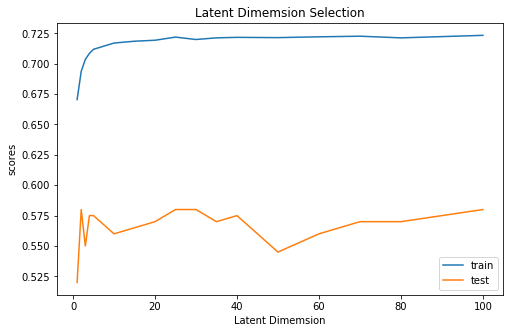

In [26]:
make_plot(latent_dim_list, train_score_list, test_score_list, 'Latent Dimemsion')

It seems like the dimension doesn't affect the result since the plot is very random. And according to previous paper, we select the dimension of 10.

**2. Learning Rage Selection**

In [27]:
latent_dim = 10
epochs = epochss[0]
learning_rate_list, train_score_list, test_score_list = [], [], []
for learning_rate in learning_rates:
    NNmodel = build_model(num_user, num_track, latent_dim)
    NNmodel.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    NNmodel.fit([np.array(user_train), np.array(track_train)], np.array(y_train), epochs=epochs, batch_size=200, validation_split = .2)
    NN_train_score = NNmodel.evaluate([np.array(user_train), np.array(track_train)], np.array(y_train))[1]
    NN_test_score = NNmodel.evaluate([np.array(user_test), np.array(track_test)], np.array(y_test))[1]
    learning_rate_list.append(learning_rate)
    train_score_list.append(NN_train_score)
    test_score_list.append(NN_test_score)

Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 6s 55us/step - loss: 0.6931 - acc: 0.5033 - val_loss: 0.6926 - val_acc: 0.5144
Epoch 2/3
104548/104548 [==============================] - 5s 48us/step - loss: 0.6911 - acc: 0.5441 - val_loss: 0.6916 - val_acc: 0.5291
Epoch 3/3
200/200 [==============================] - 0s 70us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 5s 48us/step - loss: 0.6913 - acc: 0.5269 - val_loss: 0.6871 - val_acc: 0.5657
Epoch 2/3
104548/104548 [==============================] - 4s 40us/step - loss: 0.6664 - acc: 0.6506 - val_loss: 0.6718 - val_acc: 0.5768
Epoch 3/3
200/200 [==============================] - 0s 81us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 5s 50us/step - loss: 0.6876 - acc: 0.5391 - val_loss: 0.6751 - val_acc: 0.5827
Epoch 2/3
104548/104548 [

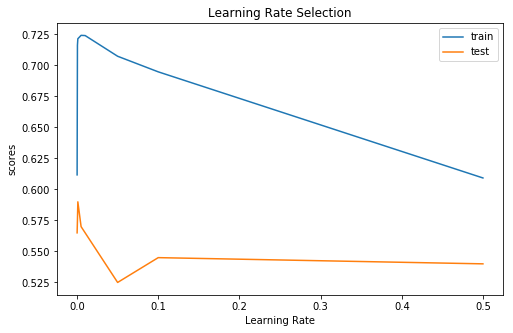

In [28]:
make_plot(learning_rate_list, train_score_list, test_score_list, 'Learning Rate')

learning rate of 0.001 looks the best

**Epochs Selection**

In [29]:
latent_dim = 10
learning_rate = 0.001
epochs = 20
NNmodel = build_model(num_user, num_track, latent_dim)
NNmodel.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
NNmodel.fit([np.array(user_train), np.array(track_train)], np.array(y_train), epochs=epochs, batch_size=200, validation_split = .2)

Train on 104548 samples, validate on 26138 samples
Epoch 1/20
104548/104548 [==============================] - 5s 52us/step - loss: 0.6876 - acc: 0.5389 - val_loss: 0.6748 - val_acc: 0.5799
Epoch 2/20
104548/104548 [==============================] - 5s 45us/step - loss: 0.6253 - acc: 0.6726 - val_loss: 0.6785 - val_acc: 0.5818
Epoch 3/20
104548/104548 [==============================] - 4s 42us/step - loss: 0.5654 - acc: 0.7113 - val_loss: 0.7411 - val_acc: 0.5808
Epoch 4/20
104548/104548 [==============================] - 4s 41us/step - loss: 0.5404 - acc: 0.7251 - val_loss: 0.8010 - val_acc: 0.5802
Epoch 5/20
104548/104548 [==============================] - 4s 41us/step - loss: 0.5278 - acc: 0.7309 - val_loss: 0.8491 - val_acc: 0.5803
Epoch 6/20
104548/104548 [==============================] - 5s 45us/step - loss: 0.5199 - acc: 0.7353 - val_loss: 0.8883 - val_acc: 0.5793
Epoch 7/20
104548/104548 [==============================] - 4s 41us/step - loss: 0.5148 - acc: 0.7373 - val_loss: 0

The result does not improve much around epochs 5 and hence we choose epochs 5.

**Create The Final Neural Network Model**

In [30]:
#Use the optimal parameter and train the final model
latent_dim = 10
learning_rate = 0.001
epochs = 5

In [31]:
#get matrix of the full dataset
no_interaction = 1
num_user, num_track, matrix = get_matrix(data_full, no_interaction)
user, track, y = get_features(matrix)
data_nn = pd.DataFrame(user, columns=['user'])
data_nn['track'] = track
data_nn['y'] = y

#get train and test data
data_copy = data_nn.copy()
data_test = pd.DataFrame(columns=['user', 'track', 'y'])
for n in range(n_playlist*900, n_playlist*1000):
    data_hide = data_copy[data_copy.user == n].iloc[0:2]
    data_test = data_test.append(data_hide)
    
data_train = data_copy.drop(data_test.index)

user_train = data_train.user
track_train = data_train.track
y_train = data_train.y

user_test = data_test.user
track_test = data_test.track
y_test = data_test.y

In [32]:
#Build the final model
NNmodel = build_model(num_user, num_track, latent_dim)
NNmodel.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
print(NNmodel.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_train (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
track_train (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 1, 10)        100000      user_train[0][0]                 
__________________________________________________________________________________________________
embedding_54 (Embedding)        (None, 1, 10)        1329200     track_train[0][0]                
__________________________________________________________________________________________________
flatten_53

In [33]:
#Fit the model
NNmodel.fit([np.array(user_train), np.array(track_train)], np.array(y_train), epochs=epochs, batch_size=200, validation_split = .2)
NN_train_score = NNmodel.evaluate([np.array(user_train), np.array(track_train)], np.array(y_train))[1]
NN_test_score = NNmodel.evaluate([np.array(user_test), np.array(track_test)], np.array(y_test))[1]

Train on 1042625 samples, validate on 260657 samples
Epoch 1/5
1042625/1042625 [==============================] - 126s 121us/step - loss: 0.5427 - acc: 0.7242 - val_loss: 0.5186 - val_acc: 0.7711
Epoch 2/5
1042625/1042625 [==============================] - 130s 124us/step - loss: 0.4545 - acc: 0.7924 - val_loss: 0.5388 - val_acc: 0.7666
Epoch 3/5
1042625/1042625 [==============================] - 124s 119us/step - loss: 0.4383 - acc: 0.8009 - val_loss: 0.5561 - val_acc: 0.7659
Epoch 4/5
1042625/1042625 [==============================] - 127s 121us/step - loss: 0.4297 - acc: 0.8055 - val_loss: 0.5694 - val_acc: 0.7653
Epoch 5/5
2000/2000 [==============================] - 0s 48us/step


In [34]:
print('The NN train score is {}'.format(round(NN_train_score, 2)))
print('The NN test score is {}'.format(round(NN_test_score, 2)))

The NN train score is 0.81
The NN test score is 0.78


In [35]:
min_train_score = 1 - np.mean(y_train)
min_test_score = 1 - np.mean(y_test)
print('The minimum train score is {}'.format(round(min_train_score, 2)))
print('The minimum test score is {}'.format(round(min_test_score, 2)))

The minimum train score is 0.5
The minimum test score is 0.5


From the result we can see that our model works much better than the minimum score which is 0.5 - 0.5.

The test score means that in test set, we successfully predict a large portion of the test tracks for each user in to the right category (with interaction or without interaction. The result means that, given a user and a track, we can define if the user and the track has possible interactions. It is logically very useful in generating a recommendation list: we can take the top 100 tracks with highest probability of interaction from our full unique tracks dataset as the recommendation list.

In the follwoing section of combined model, we will apply this idea to generate our final recommendation list.

# Combined Model: Generating Recommendation List

As we did before, we will hide one track in each playlist(user) and generate a recommendation list, see if this recommendation list contain that hidden track. However, due to our limitation of training data size and the very large tracks in the the music bank, we don't expect that for a large percent of time, we can successfully find out that exact one hidden track. In real world, the user preference can be much broader than just one "hidden" track.

We choose to combine the baseline model and Neural Network model together to generate the list. First, we will extract our previous recommendation list (including the not overlap tracks of top 5 similar playlists in baseline model). Instead of randomly select 100 of them as recommendation, we apply the trained Artifical Neural Network to rank the possible interactions and select the top 100 tracks with the highest interaction score and use them as our final recommendation list.

As far as our prediction score increase (higher than what we get in baseline model), our neural network works.

In [36]:
recom_list_combine = recommendation_list.copy()

In [37]:
recommendation_scores = np.zeros(len(track_hide))
for x in range(len(track_hide)):
    track_full_list = list(set(recom_list_combine[x]))
    existing_track = data_train[data_train['user'] == x].track
    hidden_track = list(track_test)[x*2]
    predict_track = list(Counter(track_full_list)-Counter(existing_track))
    predict_user = np.zeros(len(predict_track))+x
    
    s = NNmodel.predict([np.array(x).reshape(-1,1), np.array(hidden_track).reshape(-1,1)])
    #print('score is {}'.format(s))
    
    predictions = np.transpose(NNmodel.predict([predict_user, np.array(predict_track)]))[0]
    index = np.argsort(predictions)[-no_recommendation:]

    recommendation_list_ann = np.array(predict_track)[index]
    
    if hidden_track in recommendation_list_ann:
        recommendation_scores[x] = 1
        
total_score = np.average(recommendation_scores)

In [38]:
print('For {} percent of time, we successfully include the hidden track'.format(round(total_score*100)))

For 24.0 percent of time, we successfully include the hidden track


Just as what we have expected, even thouth the predction accuracy of neural network is very high, the probability that the recommendation list we generate that will include the hidden track is very low because:

 - The hidden track is not the exact indicator of "user preference" because the user may have higher probability to like the other traks that does not neccessarily to be the hidden track! Hence the real "user preference" for the not hidden track in other playlist will be higher than the actual "hidden track" that we hided before. But in the scope of this project, we are not able to find out the true user preference and hence, we can just use the "hidden track" as a possible indicator.
 
Therefore, even though our score is not very high, it did improve a lot comparing to our baseline model, which is basically in random basesa. This is consistant with our high neural network prediction results.

In [39]:
#calculate the running time of whole script
end = timer()
print(end-start)

2415.3134542769985
